<a href="https://colab.research.google.com/github/mjiii25/posco-academy/blob/main/multi-linear-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **다중선형 회귀분석 (BIg Data 분석-(1) 50쪽)**

In [4]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

In [3]:
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)

### **데이터 구성하기**

In [5]:
df_raw = pd.read_csv('/content/mydrive/MyDrive/체질검사.csv')

print(df_raw.shape)
df_raw.head()

(252, 14)


,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   FAT      252 non-null    float64
 1   AGE      252 non-null    int64  
 2   WEIGHT   252 non-null    float64
 3   HEIGHT   252 non-null    float64
 4   NECK     252 non-null    float64
 5   CHEST    252 non-null    float64
 6   ABDOMEN  252 non-null    float64
 7   HIP      252 non-null    float64
 8   THIGH    252 non-null    float64
 9   KNEE     252 non-null    float64
 10  ANKLE    252 non-null    float64
 11  BICEPS   252 non-null    float64
 12  FOREARM  252 non-null    float64
 13  WRIST    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


### **변수 간의 경향성 파악**

#### **그래프 분석**

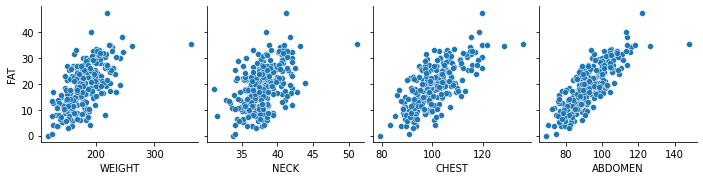

In [7]:
sns.pairplot(df_raw, 
             y_vars = 'FAT', 
             x_vars = ['WEIGHT', 'NECK', 'CHEST', 'ABDOMEN'])

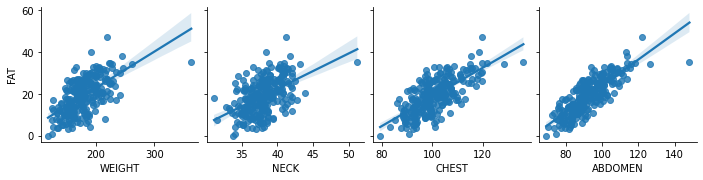

In [8]:
# 회귀 적합선 추가 : kind = 'reg'

sns.pairplot(df_raw, 
             y_vars = 'FAT', 
             x_vars = ['WEIGHT', 'NECK', 'CHEST', 'ABDOMEN'],
             kind = 'reg')

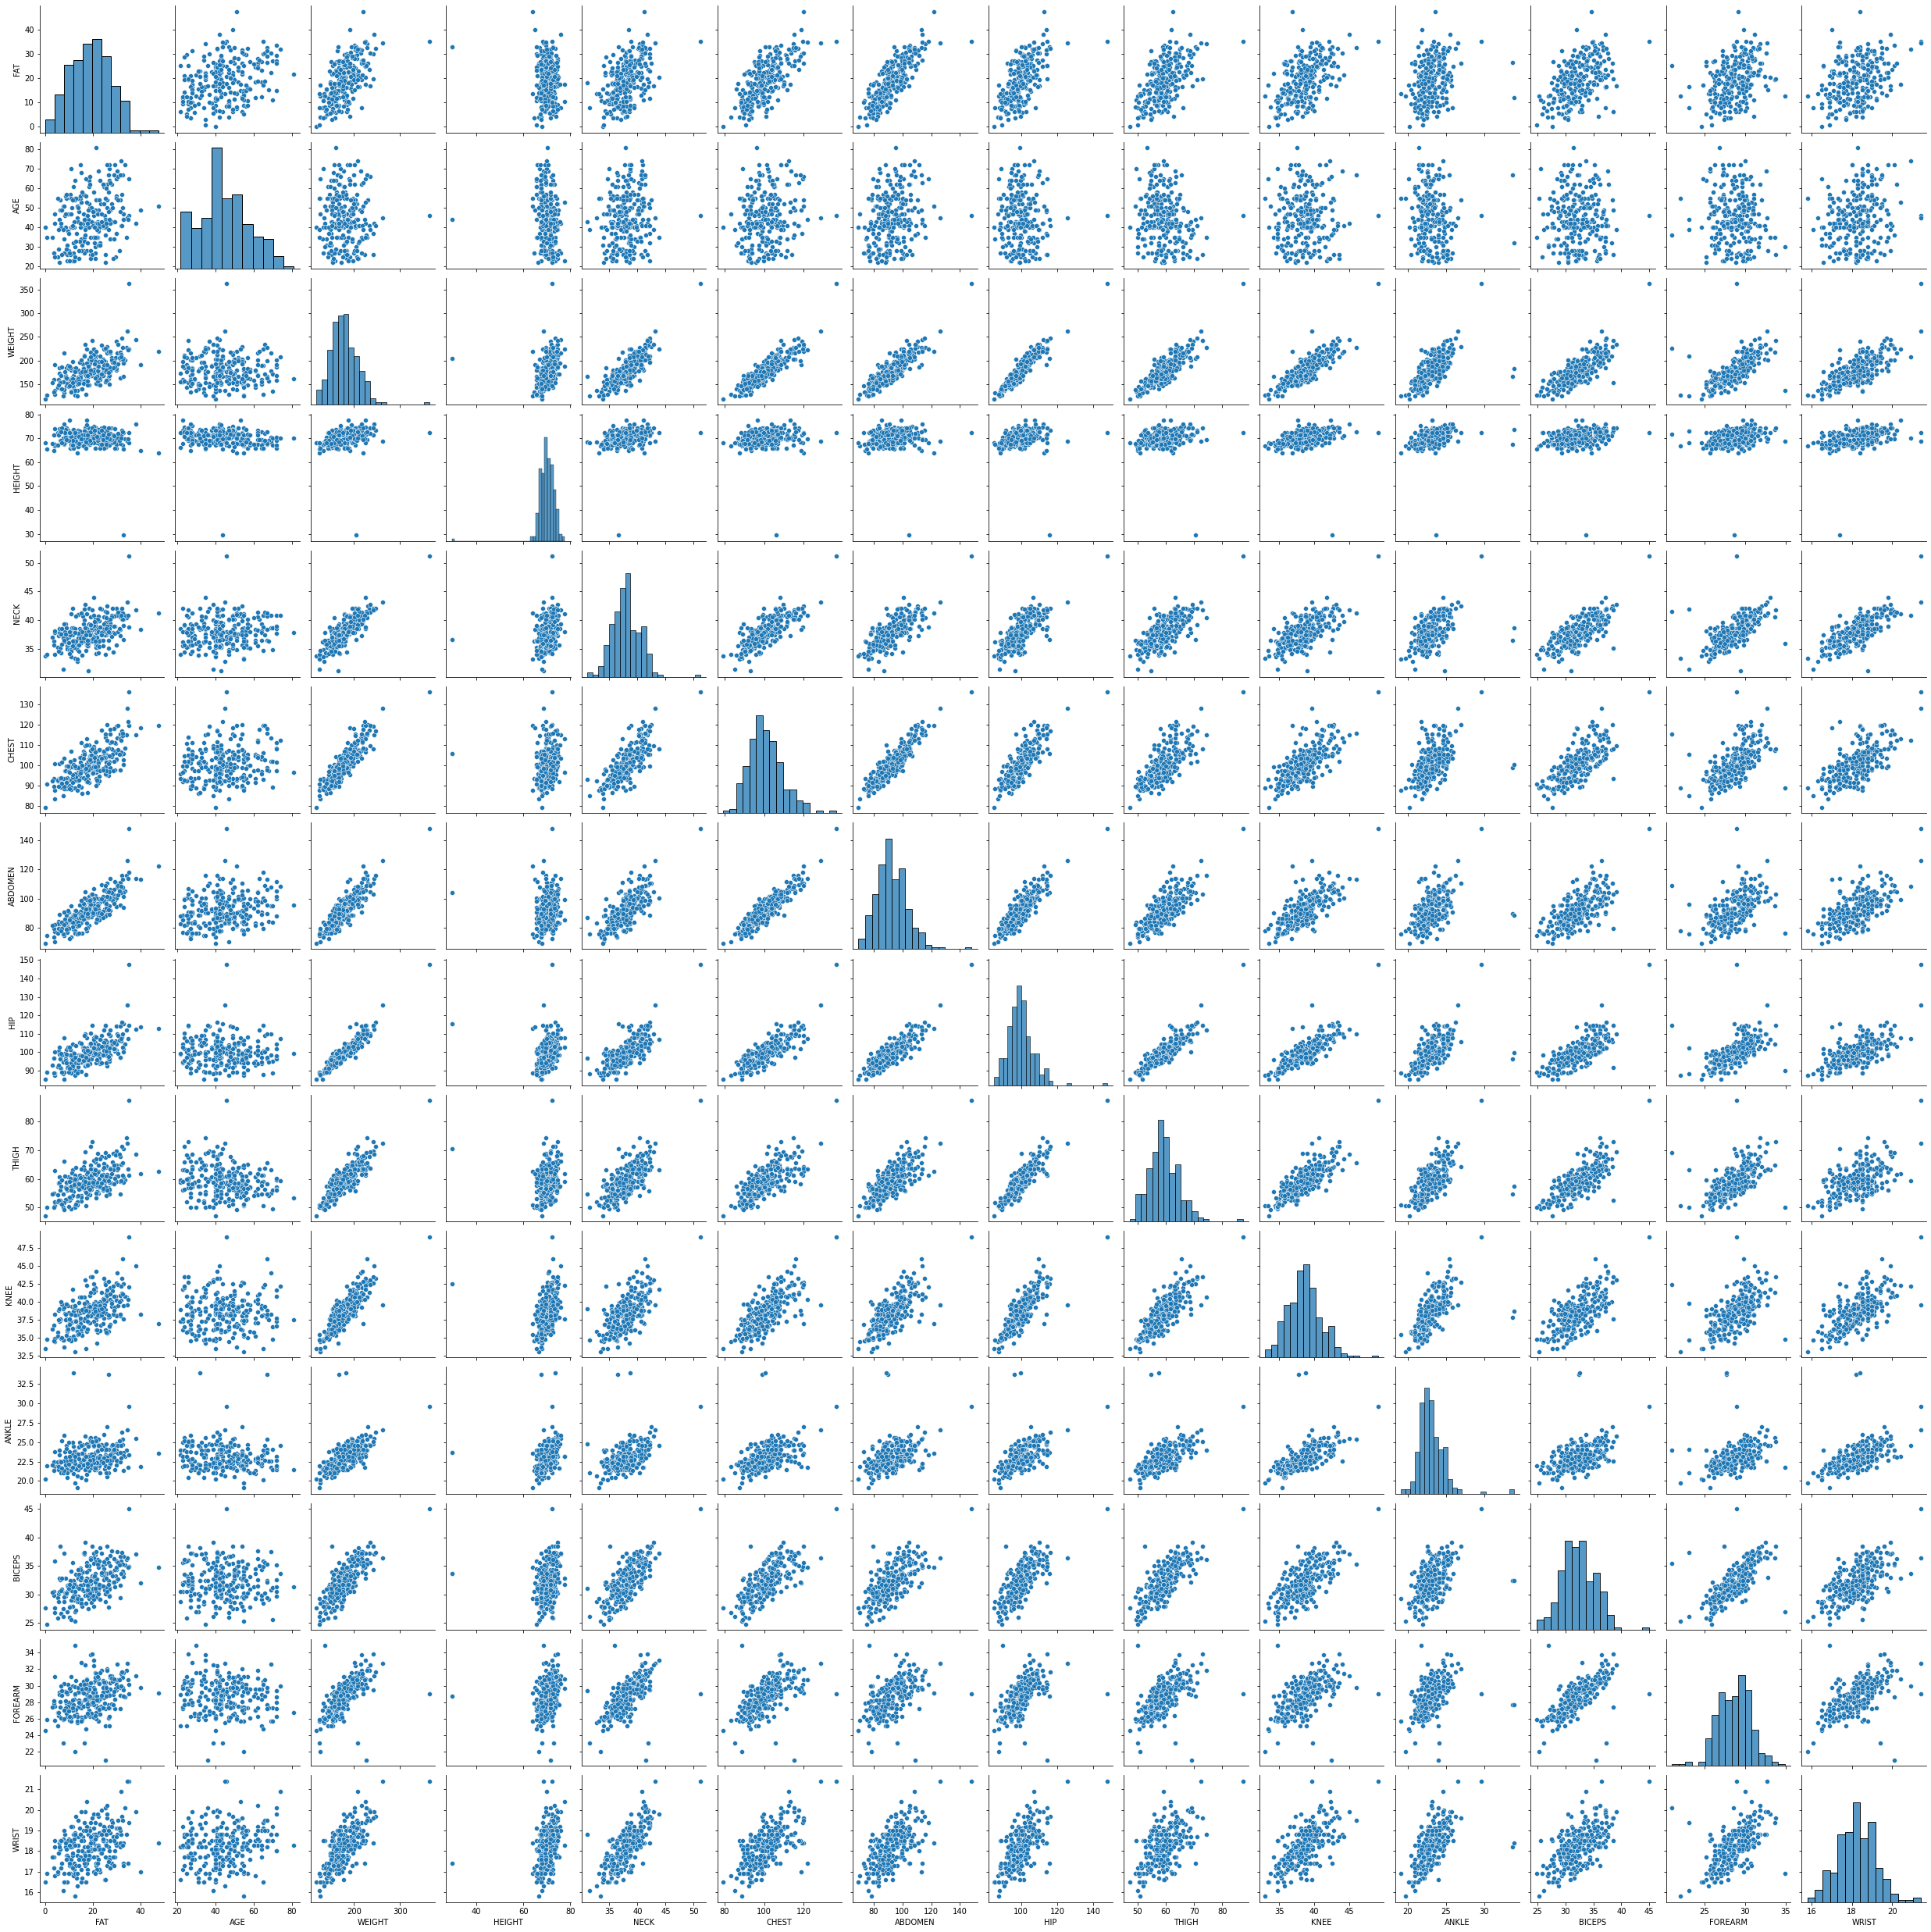

In [9]:
sns.pairplot(df_raw)

- FAT과 선형관계가 있는 설명변수 확인됨
- 설명변수 간의 선형관계 확인됨 : WEIGHT, NECK 등  -> 설명변수 간의 다중공선성 처리 필요

#### **상관관계 분석**

In [11]:
df_raw.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
FAT,1.000,0.291,0.612,-0.089,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347
AGE,0.291,1.000,-0.013,-0.172,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214
WEIGHT,0.612,-0.013,1.000,0.308,0.831,0.894,0.888,0.941,0.869,0.853,0.614,0.800,0.630,0.730
HEIGHT,-0.089,-0.172,0.308,1.000,0.254,0.135,0.088,0.170,0.148,0.286,0.265,0.208,0.229,0.322
NECK,0.491,0.114,0.831,0.254,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745
CHEST,0.703,0.176,0.894,0.135,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660
ABDOMEN,0.813,0.230,0.888,0.088,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620
HIP,0.625,-0.050,0.941,0.170,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630
THIGH,0.560,-0.200,0.869,0.148,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559
KNEE,0.509,0.018,0.853,0.286,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665


### **회귀 모델 생성**

In [12]:
df_train, df_test = train_test_split(df_raw,
                                     test_size = 0.3,
                                     random_state = 1234)

print('Train data size : {}'.format(df_train.shape))
print('Test data size : {}'.format(df_test.shape))

Train data size : (176, 14)
Test data size : (76, 14)


In [13]:
reg_model = smf.ols(formula = "FAT ~ AGE + WEIGHT + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + \
                                KNEE + ANKLE + BICEPS + FOREARM + WRIST", data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())   # 57쪽

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     41.45
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           9.76e-45
Time:                        18:02:59   Log-Likelihood:                -495.19
No. Observations:                 176   AIC:                             1018.
Df Residuals:                     162   BIC:                             1063.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -35.8408     20.905     -1.714      0.0

#### **설명변수 간의 다중공선성 확인**

In [14]:
df_train_x = df_train.drop('FAT', axis = 1)
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_train_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_train_x_const.values, i) for i in range(df_train_x_const.shape[1])]
df_vif.sort_values('VIF', ascending = True).round(2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,variable,VIF
3,HEIGHT,1.65
12,FOREARM,2.03
10,ANKLE,2.23
1,AGE,2.42
11,BICEPS,3.45
13,WRIST,3.50
4,NECK,4.25
9,KNEE,5.13
8,THIGH,8.96
5,CHEST,10.72


- WEIGHT 의 VIF가 37.21로 높고 HIP도 16.56으로 높게 나타남

In [15]:
# WEIGHT 제외

reg_model = smf.ols(formula = "FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + \
                                KNEE + ANKLE + BICEPS + FOREARM + WRIST", data = df_train)

reg_result = reg_model.fit()
print(reg_result.summary())   # 59쪽

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     43.77
Date:                Mon, 15 Aug 2022   Prob (F-statistic):           9.84e-45
Time:                        18:07:13   Log-Likelihood:                -497.32
No. Observations:                 176   AIC:                             1021.
Df Residuals:                     163   BIC:                             1062.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2082      8.590      0.257      0.7

#### **다중공선성 재확인**

In [16]:
df_train_x = df_train.drop(['FAT', 'WEIGHT'], axis = 1)
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()
df_vif['variable'] = df_train_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_train_x_const.values, i) for i in range(df_train_x_const.shape[1])]
df_vif.sort_values('VIF', ascending = True).round(2)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,variable,VIF
2,HEIGHT,1.36
11,FOREARM,2.03
9,ANKLE,2.10
1,AGE,2.33
10,BICEPS,3.37
12,WRIST,3.40
3,NECK,3.77
8,KNEE,4.64
4,CHEST,8.80
7,THIGH,8.94


- ABDOMEN의 VIF가 12.9로 다중공선성이 의심되나, 목표변수에 가장 영향이 큰 변수이므로 제거하지 않음 (다중공선성 일부 해결)